In [1]:
from __future__ import print_function

import mxnet as mx
from mxnet import nd, autograd, sym, mod
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from src.fetch_mnist import preprocessed_mnist

### Useful links

[A Practitioner’s Guide to MXNet](http://home.cse.ust.hk/~xshiab/data/MXNet.pdf)

[An introduction to the MXNet API](https://becominghuman.ai/an-introduction-to-the-mxnet-api-part-1-848febdcf8ab) blog post series on Medium

[MXNet the straight dope](https://github.com/zackchase/mxnet-the-straight-dope) - jupyter-notebook based deep learning textbook

#### Preparing data

Note that MXNet uses its own NDArrays, so `numpy` arrays need to be converted to that. We also use `mxnet.io` NDArrayIter class that splits data into batches.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = preprocessed_mnist(random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5) 
category_count = len(np.unique(y_train))

def data_iter(X, y, batch_size=5000):
  return mx.io.NDArrayIter(
    data=nd.array(X),
    label=nd.array(y),
    batch_size=batch_size)

train_iter = data_iter(X_train, y_train)
valid_iter = data_iter(X_valid, y_valid)
test_iter = data_iter(X_test, y_test)

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Logistic regression with softmax using `module` API

`mxnet.sym` is a module for symbols - nodes in computation graph (they correspond to tensors from Theano/Tensorflow).

The module also contains utilities that can be used for defining layers.

`mxnet.mod` contains classes for *Modules* - they provide high-level functionalities a'la `scikit-learn` estimators. Modules can be built with symbols, and they automatically infer weights from layers.

Below is an example of simple *Module* that performs logistic regression (it uses minibatch gradient descent for optimization).

In [3]:
data = sym.Variable('data')
hid = sym.FullyConnected(data, name='hidden', num_hidden=category_count)
out = sym.SoftmaxOutput(hid, name='softmax')

nn = mod.Module(symbol=out)

The following cell contains code that can be passed to our Module's `fit` method. It is used to save per-batch metric (here accuracy is used).

In [4]:
from mxnet.callback import LogValidationMetricsCallback

def log_to_list(lst, period=None, data_type='Train', log_output=False):
    def condition(nbatch):
      if period == None:
        return nbatch == 0
      else:
        return nbatch % period == 0
  
    def _callback(param):
        """The checkpoint function."""
        if condition(param.nbatch) and param.eval_metric is not None:
            name_value = param.eval_metric.get_name_value()
            for name, value in name_value:
                message_args = (param.epoch, param.nbatch, data_type, name, value)
                message = 'Iter[{}] Batch[{}] {}-{}={}'.format(*message_args)
                if log_output:
                  print(message)
                lst.append((message, message_args))
    return _callback

#### Training

In [5]:
train_log_list = []
eval_log_list = []

num_epoch = 200 

%time nn.fit(\
  train_iter,\
  eval_data=valid_iter,\
  batch_end_callback=log_to_list(train_log_list),\
  eval_batch_end_callback=log_to_list(eval_log_list, data_type='Valid'),\
  num_epoch=num_epoch)

CPU times: user 1min 43s, sys: 4.84 s, total: 1min 48s
Wall time: 53.3 s


In [6]:
y_test_pred_proba = nn.predict(test_iter)
y_test_pred = nd.argmax(y_test_pred_proba, axis=1)

In [7]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_pred.asnumpy())

0.91514285714285715

In [8]:
train_accs = [msg[1][4] for msg in train_log_list]
eval_accs = [msg[1][4] for msg in eval_log_list]

## Validation vs training accuracy

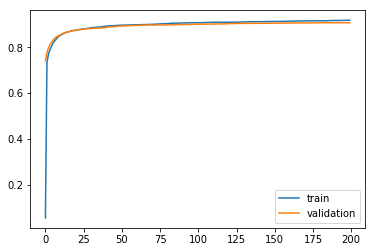

In [9]:
plt.plot(np.arange(num_epoch), train_accs, label='train')
plt.plot(np.arange(num_epoch), eval_accs, label='validation')
plt.legend()
plt.show()